# Import Character Vocab


In [1]:
import numpy as np
import json
import tensorflow as tf

In [2]:
with open('files/vocab.json', 'r') as f:
  CHAR_INDICES = json.load(f)

In [3]:
print(CHAR_INDICES)

{' ': 0, '(': 1, ')': 2, ',': 3, '-': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'O': 29, 'P': 30, 'Q': 31, 'R': 32, 'S': 33, 'T': 34, 'U': 35, 'V': 36, 'W': 37, 'X': 38, 'Y': 39, 'Z': 40, 'a': 41, 'b': 42, 'c': 43, 'd': 44, 'e': 45, 'f': 46, 'g': 47, 'h': 48, 'i': 49, 'j': 50, 'k': 51, 'l': 52, 'm': 53, 'n': 54, 'o': 55, 'p': 56, 'q': 57, 'r': 58, 's': 59, 't': 60, 'u': 61, 'v': 62, 'w': 63, 'x': 64, 'y': 65, 'z': 66, '<pad>': 67, '<unk>': 68}


# Preprocessing text data

In [4]:
look_back = 5

In [5]:
def create_dataset(text, look_back = look_back):
  """
  take text with label (text that being defined where to cut ('|')) 
  and encode text and make label
  return preprocessed text & preprocessed label
  """
  X, y = [], []
  text = '|' + text
  data = [CHAR_INDICES['<pad>']] * look_back
  for i in range(1, len(text)):
    current_char = text[i]
    before_char = text[i-1]

    if current_char == '|':
      continue
    data = data[1:] + [CHAR_INDICES[current_char]]  # X data

    target = 1 if before_char == '|' else 0  # y data
    X.append(data)
    y.append(target)
  
  return np.array(X), tf.one_hot(y, 2)

In [6]:
def text_pred_preprocessing(text, sequence_len=look_back):
  """
    take unseen (testing) text and encode it with CHAR_DICT
    //It's like create_dataset() but not return label
    return preprocessed text
  """
  X = []
  data = [CHAR_INDICES['<pad>']] * sequence_len
  for char in text:
    char = char if char in CHAR_INDICES else '<unk>'  # check char in dictionary
    data = data[1:] + [CHAR_INDICES[char]]  # X data
    X.append(data)
  return np.array(X)

In [7]:
def word_tokenize(text, class_):
    cut_indexs = []
    words = []

    # boolean index of each word 1 if cut before
    class_ = np.append(class_, 1)

    # if y_label at i is 1 so add i (index) to cut_indexs
    for i, value in enumerate(class_):
      if value == 1:
        cut_indexs.append(i)

    # add word after cutting till before ext cutting
    for i in range(len(cut_indexs)-1):
      words.append(text[cut_indexs[i]:cut_indexs[i+1]])
    
    return words

In [8]:
def decode_label(y):
  return tf.argmax(y, axis=-1).numpy()

In [9]:
with open('files/Dictionary.json', 'r') as f1, open('files/Dictionary_cut.json', 'r') as f2:
    Dict = json.load(f1)
    Dict_cut = json.load(f2)

In [10]:
total_text = 0

for key, value in Dict.items():
    print(key, len(value))
    total_text += len(value)
print('-'*15)
for key, value in Dict_cut.items():
    print(key, len(value))


alkane 10
alkane_alkyl 30
cyclo_alkane 8
cyclo_alkane_alkyl 17
alkene 25
alkene_alkyl 15
dialkene 69
cyclo_alkene 8
cyclo_alkene_alkyl 3
alkyne 9
alkyne_alkyl 9
dialkyne 49
cyclo_alkyne 8
benzene 12
benzene_alkyl 18
benzyl_phenyl 4
alcohol 36
ether 21
aldehyde 33
ketone 23
carboxylic_acid 46
ester 17
amide 25
amine 22
mixed 87
---------------
alkane 10
alkane_alkyl 30
cyclo_alkane 8
cyclo_alkane_alkyl 17
alkene 25
alkene_alkyl 15
dialkene 69
cyclo_alkene 8
cyclo_alkene_alkyl 3
alkyne 9
alkyne_alkyl 9
dialkyne 49
cyclo_alkyne 8
benz|ene 12
benzene_alkyl 18
benzyl_phenyl 4
alcohol 36
ether 21
aldehyde 33
ketone 23
carboxylic_acid 46
ester 17
amide 25
amine 22
mixed 87


In [11]:
print('key Dict:',len(Dict.keys()))
print('ket Dict_cut:',len(Dict_cut.keys()))
print(f"There are {total_text} chemical in dataset")

key Dict: 25
ket Dict_cut: 25
There are 604 chemical in dataset


# Create Dataset

In [12]:
dataset_cut_arr = []
for _, value in Dict_cut.items():
    dataset_cut_arr = np.append(dataset_cut_arr, value, axis=-1)

print('| |'.join(dataset_cut_arr)[:101])
print(len(' '.join(dataset_cut_arr).replace('|','')))

meth|ane| |eth|ane| |prop|ane| |but|ane| |pent|ane| |hex|ane| |hept|ane| |oct|ane| |non|ane| |dec|ane
12183


In [13]:
dataset_arr = []
for _, value in Dict.items():
    dataset_arr = np.append(dataset_arr, value, axis=-1)

print(' '.join(dataset_arr)[:73])
print(len(' '.join(dataset_arr)))

methane ethane propane butane pentane hexane heptane octane nonane decane
12183


In [14]:
from sklearn.model_selection import train_test_split
dataset_train_arr, dataset_val_arr, dataset_cut_train_arr, dataset_cut_val_arr = train_test_split(dataset_arr, dataset_cut_arr, test_size = 0.15, random_state = 3)

dataset_train_text = ' '.join(dataset_train_arr)
dataset_val_text = ' '.join(dataset_val_arr)
dataset_cut_train_text = '| |'.join(dataset_cut_train_arr)
dataset_cut_val_text = '| |'.join(dataset_cut_val_arr)

print(dataset_train_arr.shape)
print('-'*20)
print(dataset_train_text[:67])
print(dataset_cut_train_text[:99])
print('-'*20)
print(dataset_val_text[:74])
print(dataset_cut_val_text[:113])

(513,)
--------------------
meta-dimethylbenzene ortho-dimethylbenzene 2,2-dimethyl-3-propyloct
meta|-|di|meth|yl|benz|ene| |ortho|-|di|meth|yl|benz|ene| |2|,|2|-|di|meth|yl|-|3|-|prop|yl|oct|ane
--------------------
buta-1,3-diene 2-methoxycarbonylbenzoic acid 4-methoxybenzenecarboxylic ac
but|a|-|1|,|3|-|di|ene| |2|-|meth|oxy|carbonyl|benz|oic acid| |4|-|meth|oxy|benz|ene|carboxylic acid| |4|-|meth|o


In [15]:
X_train ,y_train = create_dataset(dataset_cut_train_text)
X_val, y_val = create_dataset(dataset_cut_val_text)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10320, 5) (10320, 2)
(1862, 5) (1862, 2)


In [16]:
training_data = tf.data.Dataset.from_tensor_slices((X_train,y_train))
training_data = training_data.batch(128)

validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_data = validation_data.batch(128)

# Create Model

## Model Architecture

In [17]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [18]:
_input_shape = (look_back, len(CHAR_INDICES))
print(_input_shape[1])

69


In [19]:
Model = Sequential(
    [
     Embedding(_input_shape[1], len(CHAR_INDICES)),
     Bidirectional(LSTM(_input_shape[1]//2, return_sequences=False),
                      merge_mode='sum',
                      weights=None),
     Dense(_input_shape[1]//4),
     Dense(2, activation='softmax')
    ],
    name='model'
)

In [20]:
Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 69)          4761      
_________________________________________________________________
bidirectional (Bidirectional (None, 34)                28288     
_________________________________________________________________
dense (Dense)                (None, 17)                595       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36        
Total params: 33,680
Trainable params: 33,680
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [21]:
Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = 'save_models/best_model.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    verbose=0,
    save_best_only=True
)

earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,   
)

callback_list = [checkpoint_callback, earlystop_callback]
history = Model.fit(training_data, validation_data=validation_data, epochs=500, callbacks=callback_list)

Epoch 1/500
81/81 [==============================] - 1s 14ms/step - loss: 0.5089 - accuracy: 0.7601 - val_loss: 0.3215 - val_accuracy: 0.8641
Epoch 2/500
81/81 [==============================] - 1s 8ms/step - loss: 0.2734 - accuracy: 0.8948 - val_loss: 0.2188 - val_accuracy: 0.9114
Epoch 3/500
81/81 [==============================] - 1s 8ms/step - loss: 0.1900 - accuracy: 0.9245 - val_loss: 0.1399 - val_accuracy: 0.9474
Epoch 4/500
81/81 [==============================] - 1s 8ms/step - loss: 0.1416 - accuracy: 0.9507 - val_loss: 0.1078 - val_accuracy: 0.9672
Epoch 5/500
81/81 [==============================] - 1s 8ms/step - loss: 0.1122 - accuracy: 0.9654 - val_loss: 0.0860 - val_accuracy: 0.9758
Epoch 6/500
81/81 [==============================] - 1s 8ms/step - loss: 0.0895 - accuracy: 0.9752 - val_loss: 0.0690 - val_accuracy: 0.9812
Epoch 7/500
81/81 [==============================] - 1s 8ms/step - loss: 0.0735 - accuracy: 0.9801 - val_loss: 0.0576 - val_accuracy: 0.9850
Epoch 8/500


<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


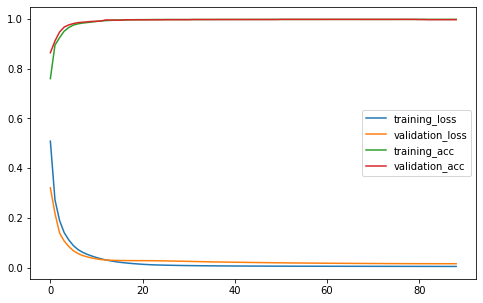

In [29]:
print(type(history.history))
print(history.history.keys())

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.plot(history.history['accuracy'], label='training_acc')
plt.plot(history.history['val_accuracy'], label='validation_acc')
plt.legend()
plt.show()

## load model & test on unseen data

In [23]:
best_model = tf.keras.models.load_model('save_models/best_model.hdf5')

In [24]:
 myText = "3-(3,4-dihydroxyphenyl)prop-2-enoic acid"
 myText_cut = "3|-|(|3|,|4|-|di|hydroxy|phen|yl|)|prop|-|2|-|en|oic acid"  

In [25]:
_, my_y = create_dataset(myText_cut)
myText_test = text_pred_preprocessing(myText)

pred_test_proba = best_model.predict(myText_test)

pred_test = decode_label(pred_test_proba)
my_y_decode = decode_label(my_y)

print(pred_test)
print(my_y_decode)

# Count same item between y (label) and pred (prediction)
elem_same = (pred_test == my_y_decode).sum()
print("\nSame =",elem_same,", Not Same =",pred_test.shape[0]-elem_same)

print("\nConfusion Matrix:")
print(tf.math.confusion_matrix(my_y_decode, pred_test, num_classes=2).numpy())

[1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0
 0 0 0]
[1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0
 0 0 0]

Same = 40 , Not Same = 0

Confusion Matrix:
[[22  0]
 [ 0 18]]


In [26]:
words = word_tokenize(myText, pred_test)
print(words)
print('|'.join(words))

['3', '-', '(', '3', ',', '4', '-', 'di', 'hydroxy', 'phen', 'yl', ')', 'prop', '-', '2', '-', 'en', 'oic acid']
3|-|(|3|,|4|-|di|hydroxy|phen|yl|)|prop|-|2|-|en|oic acid


In [27]:
import nltk
reference = [myText_cut.split('|')]
score = nltk.translate.bleu_score.sentence_bleu(reference,words)

In [28]:
print(score)

1.0
